### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

$$
1) \dfrac{\partial L}{\partial a} = - 2 y_i + 2 a(x_i) \\ \\
2) \dfrac{\partial L}{\partial a} = - y_i \exp(- a(x_i) y_i) \\ \\
3) \dfrac{\partial L}{\partial a} = \dfrac{- y_i \exp(- a(x_i) y_i)}{1 + \exp(- a(x_i) y_i)} = \dfrac{- y_i}{1 + \exp(a(x_i) y_i)}
$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [228]:
import numpy as np

from sklearn import base
from sklearn.datasets import load_wine, make_classification
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from scipy.special import softmax

In [235]:
class MyGradientBoostingClassifier(base.BaseEstimator):

    def __init__(self, loss="mse", learning_rate=0.1, n_estimators=100, colsample=1., subsample=1., *args, **kwargs):
        """
        loss -- один из 3 лоссов: mse, exp, log
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        subsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs

    def get_loss(self, pred, y):
        if self.loss =="mse":
            return ((y - pred) * (y - pred)).sum()
        elif self.loss == "exp":
            return (np.exp(- pred * y)).sum()
        else:
            return (np.log(np.ones(y.shape[0]) + np.exp(- pred * y))).sum()
    
    def grad(self, pred, y):
        if self.loss =="mse":
            return - 2 * y + 2 * pred
        elif self.loss == "exp":
            return - y * np.exp(- pred * y)
        else:
            return - y * np.exp(- pred * y) / (1 + np.exp(- pred * y))

    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.n_classes = np.unique(y).shape[0]
        self.init_model = init_model
        self.models = [base_model(*self.args, **self.kwargs) for i in range(self.n_estimators)]

        if init_model is None:
            last_model_pred = np.zeros(y.shape[0], dtype=np.float64)
        else:
            self.zero_model = init_model()
            self.zero_model.fit(X, y)
            last_model_pred = self.zero_model.predict(X).astype(np.float64)
            
        self.losses = np.zeros(self.n_estimators + 1)
        self.losses[0] = self.get_loss(np.sign(last_model_pred), y)

        self.feats = np.repeat(np.arange(int(X.shape[1] * self.colsample)), self.n_estimators).reshape(
            self.n_estimators, int(X.shape[1] * self.colsample))
        for i in range(self.n_estimators):
            objs = np.random.choice(y.shape[0], int(y.shape[0] * self.subsample), replace=False)
            self.feats[i] = np.random.choice(X.shape[1], int(X.shape[1] * self.colsample), replace=False)
            self.models[i].fit(X[objs][:, self.feats[i]], - self.grad(last_model_pred[objs], y[objs]))
            last_model_pred += self.learning_rate * self.models[i].predict(X[:, self.feats[i]])
            self.losses[i + 1] = self.get_loss(last_model_pred, y)
        return last_model_pred
        
    def predict(self, X):
        pred = np.asarray([self.models[i].predict(X[:, self.feats[i]])
                        for i in range(self.n_estimators)]).sum(axis=0)
        if self.init_model is None:
            pred = pred * self.learning_rate
        else:
            pred = pred * self.learning_rate + self.zero_model.predict(X)
        return pred.round().astype(int)

In [242]:
my_clf = MyGradientBoostingClassifier(loss="mse", n_estimators=100, learning_rate=0.2, criterion="friedman_mse", max_depth=3)
clf = GradientBoostingClassifier()

In [243]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [244]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_train), y_true=y_train))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [189]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [190]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [191]:
np.unique(y, return_counts=True)

(array([0, 1]), array([11931,  8709]))

In [196]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [197]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full)

In [199]:
"""
Подбираем:
а) число итераций - n_estimators
б) размер шага - learning_rate
в) процент случайных фичей при построении одного дерева - colsample
д) процент случайных объектов при построении одного дерева - subsample
е) параметры базового алгоритма - max_depth
ж) лосс - loss
"""

from tqdm import tqdm


n_estimators_list = [50, 100, 250, 500, 750, 1000, 1250, 1500, 1750] 
scores = []
train_scores = []

for n_est in tqdm(n_estimators_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=n_est,
        max_depth=3
    )
    clf.fit(X_train, y_train)
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 9/9 [05:07<00:00, 34.14s/it]


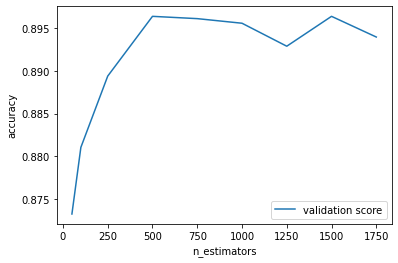

In [200]:
import matplotlib.pyplot as plt 

plt.plot(n_estimators_list, scores, label='validation score')
#plt.plot(n_estimators_list, train_scores, label='train score')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [205]:
loss_list = ["mse", "exp", "log"] 
scores = []
train_scores = []

for loss in tqdm(loss_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        loss=loss,
        max_depth=3
    )
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 3/3 [01:12<00:00, 24.20s/it]


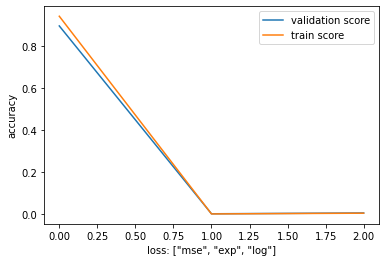

In [206]:
plt.plot([0, 1, 2], scores, label='validation score')
plt.plot([0, 1, 2], train_scores, label='train score')
plt.xlabel('loss: ["mse", "exp", "log"]')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [207]:
learning_rate_list = [0.001, 0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 1.]
scores = []
train_scores = []

for learning_rate in tqdm(learning_rate_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        learning_rate=learning_rate,
        loss="mse",
        max_depth=3
    )
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 11/11 [04:33<00:00, 24.89s/it]


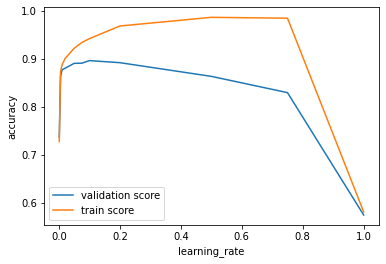

In [208]:
plt.plot(learning_rate_list, scores, label='validation score')
plt.plot(learning_rate_list, train_scores, label='train score')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [209]:
learning_rate_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
n_estimators_list = [50, 100, 250, 500, 750] 
scores = np.zeros((5, 6))
train_scores = np.zeros((5, 6))

for n_est_i in tqdm(range(5)):
    for learning_rate_i in tqdm(range(6)):
        clf = MyGradientBoostingClassifier(
            n_estimators=n_estimators_list[n_est_i],
            learning_rate=learning_rate_list[learning_rate_i],
            loss="mse",
            max_depth=3
        )
        clf.fit(X_train, y_train)
        train_scores[n_est_i, learning_rate_i] = (accuracy_score(clf.predict(X_train), y_train))
        scores[n_est_i, learning_rate_i] = (accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 5/5 [06:54<00:00, 82.98s/it] 


In [214]:
scores.max(), scores # - learning_rate = 0.1, n_estimators = 500

(0.8963939720129172,
 array([[0.73923574, 0.82561895, 0.86114101, 0.87325081, 0.88374596,
         0.88266954],
        [0.82427341, 0.8565662 , 0.87809473, 0.8810549 , 0.88805167,
         0.88482239],
        [0.86329386, 0.87405813, 0.88724435, 0.8893972 , 0.88912809,
         0.87351991],
        [0.87728741, 0.88078579, 0.89074273, 0.89639397, 0.89289559,
         0.86167922],
        [0.88024758, 0.88455328, 0.89370291, 0.89585576, 0.89262648,
         0.84956943]]))

In [218]:
colsample_list = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.]
scores = []
train_scores = []

for colsample in tqdm(colsample_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.1,
        loss="mse",
        colsample=colsample,
        max_depth=3
    )
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 8/8 [01:49<00:00, 13.71s/it]


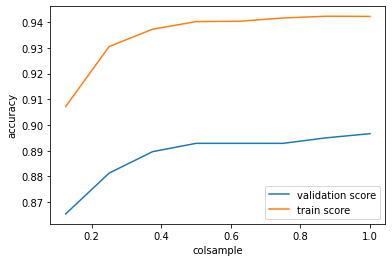

In [219]:
plt.plot(colsample_list, scores, label='validation score')
plt.plot(colsample_list, train_scores, label='train score')
plt.xlabel('colsample')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [220]:
subsample_list = [0.001, 0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.5, 0.75, 1.]
scores = []
train_scores = []

for subsample in tqdm(subsample_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.1,
        loss="mse",
        colsample=1.,
        subsample=subsample,
        max_depth=3
    )
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 11/11 [01:16<00:00,  6.94s/it]


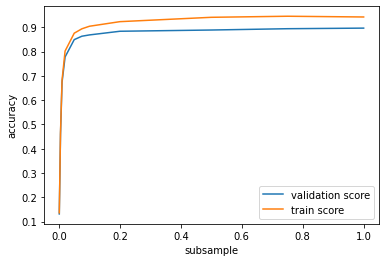

In [221]:
plt.plot(subsample_list, scores, label='validation score')
plt.plot(subsample_list, train_scores, label='train score')
plt.xlabel('subsample')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [222]:
scores

[0.13159311087190528,
 0.4593649085037675,
 0.6733046286329386,
 0.7777179763186222,
 0.8490312163616792,
 0.8630247578040904,
 0.8684068891280947,
 0.8834768568353067,
 0.8885898815931109,
 0.8939720129171151,
 0.8963939720129172]

In [223]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8]
scores = []
train_scores = []

for max_depth in tqdm(max_depth_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.1,
        loss="mse",
        colsample=1.,
        subsample=1.,
        max_depth=max_depth
    )
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

100%|██████████| 7/7 [03:46<00:00, 32.38s/it]


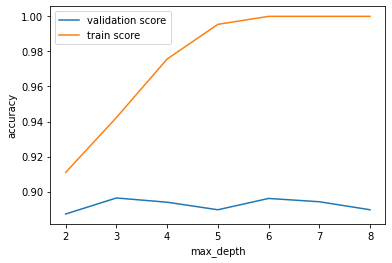

In [224]:
plt.plot(max_depth_list, scores, label='validation score')
plt.plot(max_depth_list, train_scores, label='train score')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [225]:
scores

[0.8872443487621098,
 0.8963939720129172,
 0.8939720129171151,
 0.8896663078579118,
 0.8961248654467169,
 0.8942411194833154,
 0.8896663078579118]

In [227]:
clf = MyGradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    loss="mse",
    colsample=1.,
    subsample=1.,
    max_depth=3
)
clf.fit(X_train_full, y_train_full)
accuracy_score(clf.predict(X_test), y_test)

0.9089147286821705

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [240]:
clf = MyGradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    loss="mse",
    colsample=1.,
    subsample=1.,
    max_depth=3
)
clf.fit(X_train_full, y_train_full, base_model=RandomForestRegressor)
accuracy_score(clf.predict(X_test), y_test)

0.9055232558139535

In [241]:
n_clf = 20
clfs = [MyGradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    loss="mse",
    colsample=1.,
    subsample=1.,
    max_depth=3
) for i in range(n_clf)]

idx = [np.random.choice(X_train_full.shape[0], int(X_train_full.shape[0] * 0.7), replace=False) for i in range(n_clf)]
for i in tqdm(range(n_clf)):
    clfs[i].fit(X_train_full[idx[i], :], y_train_full[idx[i]])

pred = np.mean([clfs[i].predict(X_test) for i in range(n_clf)], axis=0).astype(int)
accuracy_score(pred, y_test)

100%|██████████| 20/20 [05:49<00:00, 17.46s/it]


0.8866279069767442

Улучшить результат не удалось, что может быть связано с переобучением из-за сложности модели.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [236]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.tree import DecisionTreeClassifier

algorithm_list = [RandomForestClassifier, RandomForestRegressor,
                  DecisionTreeClassifier, DecisionTreeRegressor, 
                  SGDClassifier, Lasso, 
                  KNeighborsClassifier, KNeighborsRegressor, 
                  LinearSVC, LinearSVR]
scores = []
train_scores = []

for algorithm in tqdm(algorithm_list):
    clf = MyGradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.1,
        loss="mse",
        colsample=1.,
        subsample=1.,
        max_depth=3
    )
    clf.fit(X_train, y_train, init_model=algorithm)
    train_scores.append(accuracy_score(clf.predict(X_train), y_train))
    scores.append(accuracy_score(clf.predict(X_val), y_val))

 80%|████████  | 8/10 [02:24<00:39, 19.79s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
 90%|█████████ | 9/10 [02:46<00:20, 20.33s/it]/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
100%|██████████| 10/10 [03:08<00:00, 18.84s/it]


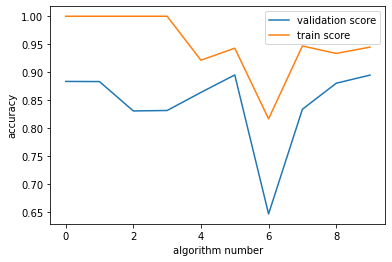

In [237]:
plt.plot(np.arange(10), scores, label='validation score')
plt.plot(np.arange(10), train_scores, label='train score')
plt.xlabel('algorithm number')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [238]:
scores

[0.8834768568353067,
 0.8832077502691066,
 0.8307319698600646,
 0.8315392895586652,
 0.8638320775026911,
 0.895048439181916,
 0.6466630785791173,
 0.8336921420882669,
 0.8802475780409041,
 0.8947793326157158]

In [239]:
clf = MyGradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    loss="mse",
    colsample=1.,
    subsample=1.,
    max_depth=3
)
clf.fit(X_train_full, y_train_full, init_model=Lasso)
accuracy_score(clf.predict(X_test), y_test)

0.9098837209302325

Результат увеличился на 0.001, что незначительно. Это можно объяснить тем, что алгоритм градиентного бустинга позволяет компенсировать недостатки начальной модели, а поэтому даже инициализация константой позволяет получить хороший результат.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

